 # Проект по прогнозированию температуры стали для оптимизации производственных расходов

## Цель проекта:
- оптимизировать производственные расходы фирмы "Как заколялась сталь" за счет уменьшения потребления электроэнергии на этапе обработки стали. Для этого создать модель машинного обучения, которая предсказывает температуру выплавки стали.

- объект моделирования - один процесс варки (партия). 

- для решения поставленной задачи необходимо спрогнозировать последнюю температуру по партии (целевая метрика).

## Описание этапа обработки стали:
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы над проектом:

1. Загрузка данных


2. Исследовательский анализ данных (выявление аномалий и пропущенных значений, визуализация основных признаков)


3. Предобработка данных (удаление партий с аномалиями, замена пропущенных значений в данных о сыпучих металлах и проволоке на 0, удаление партий, в которых отсутствуют сведения о температуре нагрева, создание единого датасета, генерация дополнительных признаков (энергия), исследование мультиколлинеарности в данных)


4. Выделение целевого признака и разбивка на тестовые и обучающие выборки


5. Поиск лучшей модели (минимум две модели), подбор гиперпараметров и оценка с помощью кросс-валидации


6. Тестирование модели с наилучшими параметрами


7. Сравнение метрик тестовой и константной модели


8. Исследование важности признаков и ошибок модели


# Импорты

In [139]:
! pip install shap
! pip install catboost
! pip install optuna 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.dummy import DummyRegressor

import optuna
import joblib

# Исследовательский анализ данных

## Данные об электродах

Основная информация:

In [141]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [142]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Всего 14876 строк, пропуски в данных отсутствуют, типы данных соответсвуют содержанию ячейки. Посмотрим на статистическиое распределение данных:

In [143]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Минимальная реактивная мощность отрицательная. Похоже на выброс. Найдем партию нагрева, в которой этот выброс произошел, а также посмотрим на топ 5 самых минимальных значений реактивной мощности:

In [144]:
arc.sort_values(by = ['Реактивная мощность']).head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525


Это 2116 партия. Так же мы видим, что следующее за отрицательным значение реактивной мощности положительное и между ними очень сильная разница, при этом последующие значения не слишком отличаются друг от друга. Однозначно в партии 2116 ошибочное значение реактивной мощности.

Далее посмотрим на количество итераций обработки в одной партии нагрева:

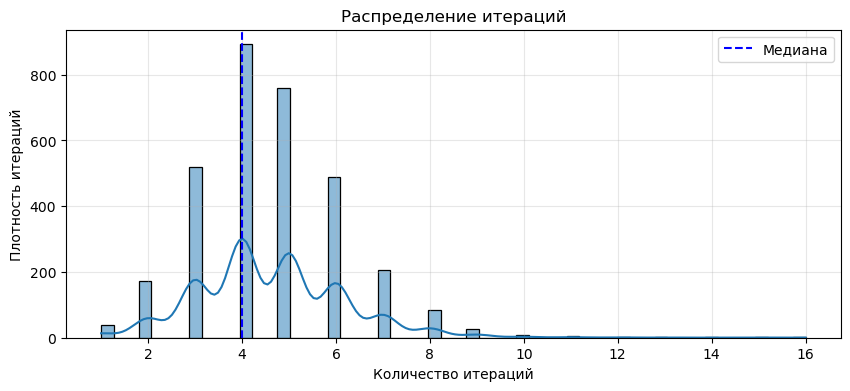

In [145]:
# Подсчет количества уникальных значений
value_counts = arc['key'].value_counts()
median_count = value_counts.median()

# Построение гистограммы
plt.figure(figsize=(10, 4)) 
sns.histplot(value_counts, kde=True) 
plt.axvline(x=median_count, color='b', linestyle='--', label='Медиана')
plt.xlabel('Количество итераций')  
plt.ylabel('Плотность итераций')  
plt.title('Распределение итераций')  
plt.grid(alpha=0.3) 
plt.legend()  
plt.show()  

Обычно в каждой партии около 4 итерации, минимальное значение - 1 итерация, максимальное значение - 16 итераций. 

Посмотрим теперь на изменение активной и реакитвной мощности во времени:

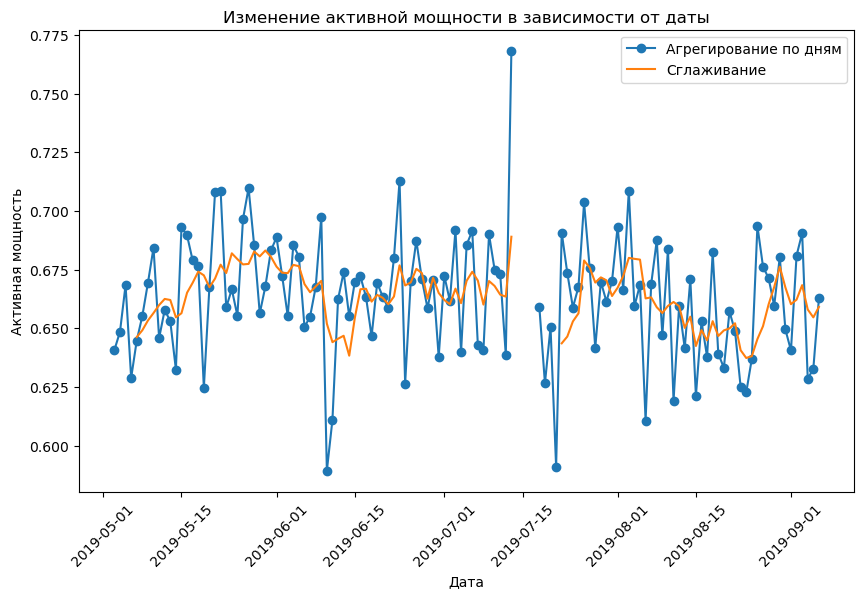

In [146]:
# Агрегирование данных по времени (каждый день)
electrode_agg = arc.resample('D', on='Начало нагрева дугой').mean()

# Применение скользящего среднего с окном 5 точек
electrode_smooth = electrode_agg['Активная мощность'].rolling(window=5).mean()

plt.figure(figsize=(10, 6))
plt.plot(electrode_agg.index, electrode_agg['Активная мощность'], marker='o', linestyle='-', label='Агрегирование по дням')
plt.plot(electrode_agg.index, electrode_smooth, marker='', linestyle='-', label='Сглаживание')
plt.xlabel('Дата')
plt.ylabel('Активная мощность')
plt.title('Изменение активной мощности в зависимости от даты')
plt.xticks(rotation=45)
plt.legend()
plt.show()


для корректного отображения реактивной мощности заменим на этом этапе выброс на медианное значение по столбцу:

In [147]:
median_value = arc['Реактивная мощность'].median()
arc.loc[9780, 'Реактивная мощность'] = median_value
arc.loc[9780]

key                                    2116
Начало нагрева дугой    2019-07-28 02:22:08
Конец нагрева дугой     2019-07-28 02:23:57
Активная мощность                  0.705344
Реактивная мощность                0.441639
Name: 9780, dtype: object

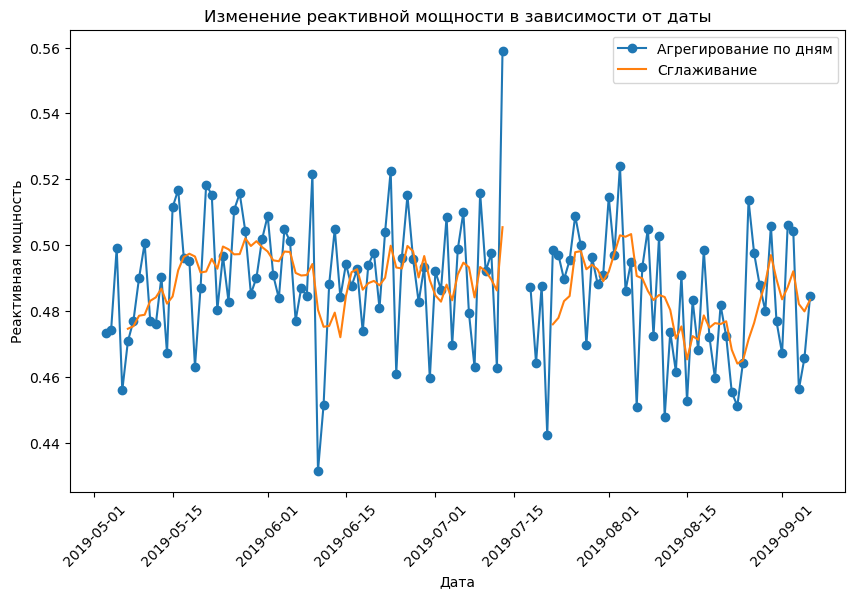

In [148]:
# Агрегирование данных по времени (каждый день)
electrode_agg = arc.resample('D', on='Начало нагрева дугой').mean()

# Применение скользящего среднего с окном 5 точек
electrode_smooth = electrode_agg['Реактивная мощность'].rolling(window=5).mean()

plt.figure(figsize=(10, 6))
plt.plot(electrode_agg.index, electrode_agg['Реактивная мощность'], marker='o', linestyle='-', label='Агрегирование по дням')
plt.plot(electrode_agg.index, electrode_smooth, marker='', linestyle='-', label='Сглаживание')
plt.xlabel('Дата')
plt.ylabel('Реактивная мощность')
plt.title('Изменение реактивной мощности в зависимости от даты')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Графики очень схожи, на обоих есть разрыв во времени. В целом процесс не имеет каких-либо особенных тенденций во времени, есть скачки мощности, скорей всего они связаны с составом используемой легирующей смеси. От состава сырья непосредственно зависит и оптимальная температура плавления и свойства электрической проводимости материалов, что напрямую влияет на показатели мощности.

Посмотрим, в какой промежуток времени произошел разрыв:

In [149]:
# Отсортировать временной ряд по дате или времени
sorted_dates = arc['Начало нагрева дугой'].sort_values()

# Вычислить разницу между каждой парой последовательных дат
time_diff = sorted_dates.diff()

# Найти индексы, где разница превышает пороговое значение
threshold = pd.Timedelta(days=1)  # Пример порогового значения - 1 день
gap_indices = time_diff[time_diff > threshold].index

# Вывести индексы, где обнаружены разрывы
print("Индексы разрывов:", gap_indices)


Индексы разрывов: Int64Index([8733], dtype='int64')


In [150]:
# Посмотрим на индекс разрыва, выведем часть строк до момента разрыва и часть после:
start_row = 8731

five_rows = arc.iloc[start_row:start_row+5]
five_rows

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
8731,1899,2019-07-13 06:53:45,2019-07-13 06:57:08,0.757284,0.505066
8732,1899,2019-07-13 06:59:31,2019-07-13 07:00:27,1.267711,1.017864
8733,1900,2019-07-18 05:12:00,2019-07-18 05:13:16,0.872761,0.767688
8734,1900,2019-07-18 05:17:58,2019-07-18 05:21:53,0.418361,0.365692
8735,1900,2019-07-18 05:46:10,2019-07-18 05:50:41,0.785243,0.524853


Да, действительно, есть временной разрыв в несколько дней, между последней записью от 13 июля и следующей записью 18 июля прошло 4 дня. Стоит уточнить причину отсутсвия данных. Можно предположить, что данные за этот период утеряны.

## Объем и время подачи сыпучих металлов

In [151]:
bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

In [152]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Из первых пяти строк таблицы мы видим, что в первой партии участвуют металлы с номерами 4, 12, 14 и 15. Подобным образом можно описать и другие партии.

In [153]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В данных очень много пропуском, посмотрим на процентное соотношение пропущенных данных:

In [154]:
bulk.isna().mean()

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

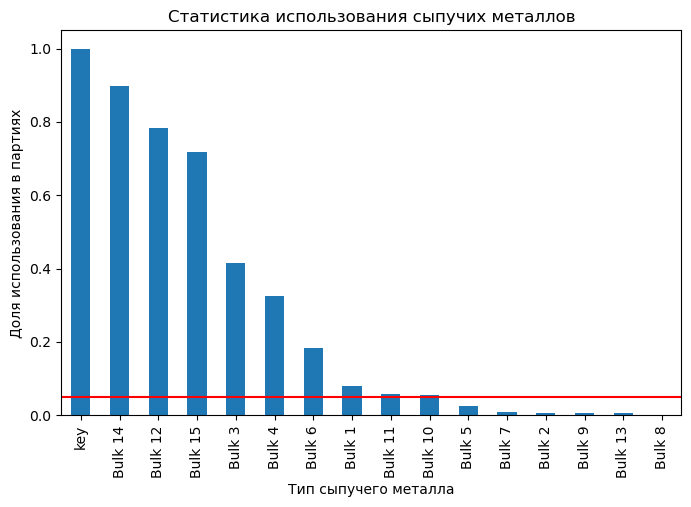

In [155]:
plt.figure(figsize = (8,5))
ax = (~bulk.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.05, color='r', linestyle='-')
ax.set_title('Статистика использования сыпучих металлов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего металла')
plt.show()

Из графика мы видим, что смеси №5, 7, 2, 9, 13 и 8 используются менее в 5% партий.

In [156]:
bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [157]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [158]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


В данной таблице мы видим время загрузки сыпучих металлов, для дальнейшей работы эти сведения нам не пригодятся.

## Данные о продувке газом

In [159]:
gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

In [160]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [161]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [162]:
gas['key'].nunique()

3239

Пропуски отсутствуют. Типы данных соответствуют содержанию ячеек. Информация о времени отсутсвует, есть только сам факт продувки газом. Партии не повторяются, следовательно продувка происходит только один раз за весь производтвенный процесс.

In [163]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Визуализируем данные о газе:

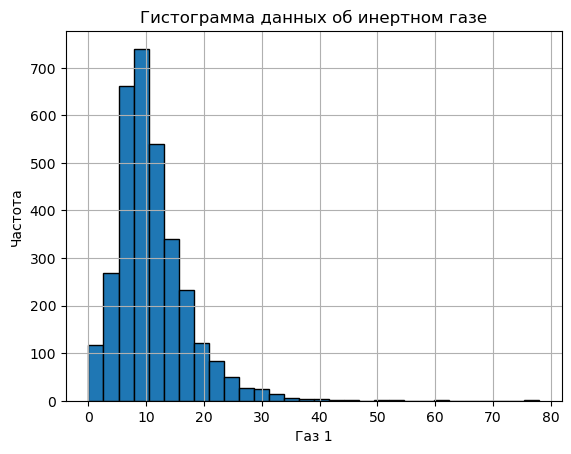

In [164]:
plt.hist(gas['Газ 1'], bins=30, edgecolor='black')
plt.xlabel('Газ 1')
plt.ylabel('Частота')
plt.title('Гистограмма данных об инертном газе')
plt.grid(True)
plt.show()

Выбросы действительно есть (это видно и из статистической отчетности, заметная разница между минимальным и максимальным значением). В целом распределение значений смещено влево.

## Данные о температуре

По условию задачи именно эта переменная нас интересует и модель должна предсказать ее для процесса выплавки стали в зависимости от остальных известных условий (таких как подача смесей, продувка газом, мощность электродов). 

In [165]:
temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv', parse_dates=[1]) 

In [166]:
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [167]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [168]:
temp.isna().mean()

key             0.000000
Время замера    0.000000
Температура     0.189421
dtype: float64

Есть пропуски в столбце температура (около 19% данных отсутствуют). 

In [169]:
temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


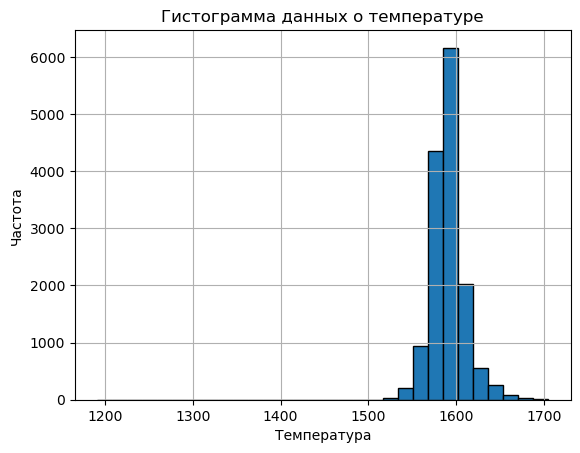

In [170]:
plt.hist(temp['Температура'], bins=30, edgecolor='black')
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.title('Гистограмма данных о температуре')
plt.grid(True)
plt.show()

При анализе статистических сведений о температуре стали можно сделать вывод, что выбросы почти отсутствуют, стандартное отклонение в 20 градусов. Но при визуализации можно заметить, что температура ниже 1500 и выше 1700 бывает крайне редко, этих значений настолько мало, что они почти не видны на графике, но при этом создают смещение вправо, распределение нельзя назвать нормальным.

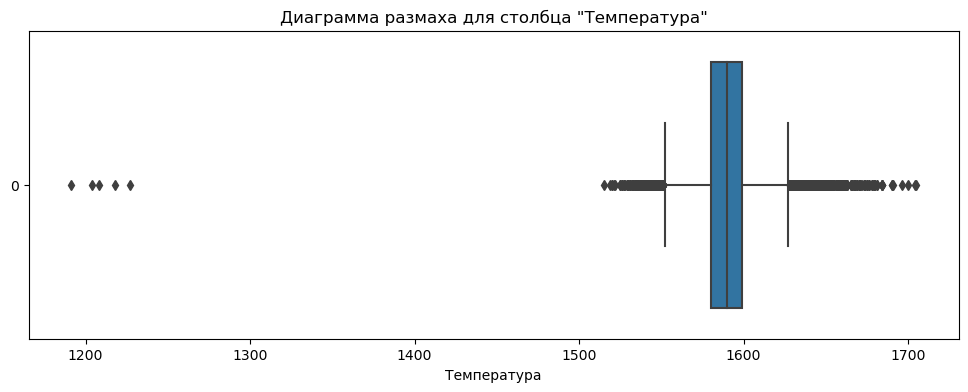

In [171]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=temp['Температура'], orient='h')
plt.xlabel('Температура')
plt.title('Диаграмма размаха для столбца "Температура"')
plt.show()

На диаграмме размаха очень хорошо видно, что есть выбросы - температура ниже плавления стали, то есть ниже 1450. 

## Данные о проволочных материалах

In [172]:
wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

In [173]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [175]:
wire.isna().mean()

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

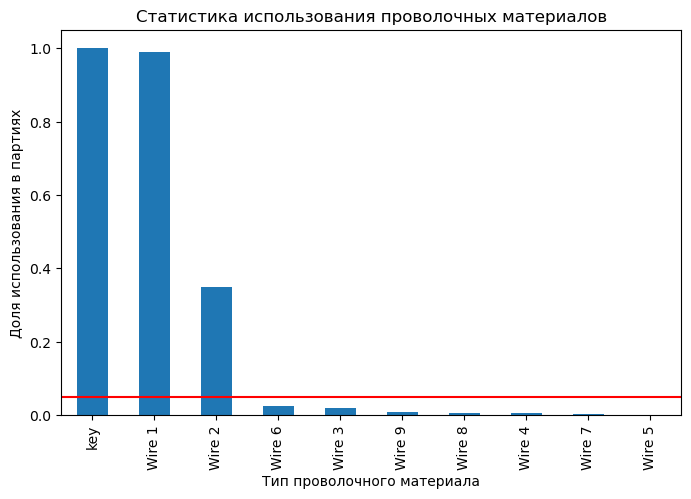

In [176]:
plt.figure(figsize = (8,5))
ax = (~wire.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.05, color='r', linestyle='-')
ax.set_title('Статистика использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочного материала')
plt.show()

По факту в производстве партий используются только проволочные материалы №1 и №2.

In [177]:
wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9])

In [178]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [179]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Во второй таблице мы также видим время подачи проволочных материалов. Эти данные для построения модели нам не пригодятся.

## Промежуточный вывод:

На исследовательском этапе мы обнаружили, что часть данных с производсвенного процесса утеряна, это видно на графиках визализации процесса нагрева дугой. Отсутствуют данные в период с 14 по 17 июля 2019 года.

Также обнаружены аномалии в данных - отрицателльная реактивная мощность, температура ниже температуры плавления стали. Далее необходимо удалить партии с аномальными значениями.

Обнаружены пропуски в данных: партии в которых отсутсвуют сведения о температуре также необходимо удалить, сведения о легирующих элементах, которые не участвуют в выплавке стали заполнить нулевыми значениями. 

Данные о производстве стали изучены, информации для прогнозирования температуры достаточно. Можно приступать к созданию единого датасета и выбору модели машинного обучения.

## Предобработка данных

### Подготовка таблицы с данными об электродах

Удалим партию 2116, в которой обнаружена отрицательная реактивная мощность:

In [180]:
arc = arc.drop(arc[arc['key'] == 2116].index)

Также сгенерируем дополнительные признаки - время нагрева дугой (в часах), энергия, затраченная на нагрев стали и кол-во итераций нагрева дугой:

In [181]:
arc['Время нагрева дугой'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds()/3600

In [182]:
arc['Энергия'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)*arc['Время нагрева дугой']

In [183]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.063333,0.023504
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.051389,0.046369
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.047778,0.034521
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.101389,0.065175
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0.041111,0.044397


Выполним агрегацию данных по ключу:

In [184]:
agg_arc = arc.groupby('key').agg({
    'Начало нагрева дугой': 'first',
    'Конец нагрева дугой': 'last',
    'Активная мощность': 'mean',
    'Реактивная мощность': 'mean',
    'Время нагрева дугой': 'sum',
    'Энергия': 'sum'
}).reset_index()

Частота нагрева дугой напрямую влияет на затраты энергии при процессе плавки стали. Чем больше итераций за партию, тем больше электроэнергии затрачено. Таким образом количество итераций может помочь в прогнозировании процесса нагрева и оптимизировать сам процесс. 

In [185]:
agg_arc['Количество итераций'] = arc.groupby('key').size().reset_index(name='Количество')['Количество']

Если в таблице присутствует время нагрева дугой, то столбцы с началом нагрева и концом нагрева уже не нужны и можно их удалить:

In [186]:
agg_arc.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой'], inplace=True)

In [187]:
agg_arc.head()

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Энергия,Количество итераций
0,1,0.607346,0.428564,0.305000,0.213967,5
1,2,0.534852,0.363339,0.225278,0.133822,4
2,3,0.812728,0.587491,0.181944,0.200788,5
3,4,0.676622,0.514248,0.205833,0.189849,4
4,5,0.563238,0.421998,0.241389,0.142269,4


In [188]:
agg_arc.describe()

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Энергия,Количество итераций
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,1622.907874,0.661332,0.485966,0.220748,0.182136,4.628696
std,934.844882,0.128392,0.097600,0.092344,0.085819,1.608860
min,1.000000,0.267676,0.196228,0.015833,0.009286,1.000000
25%,817.000000,0.573010,0.417393,0.158611,0.123573,4.000000
50%,1623.000000,0.652864,0.481626,0.213889,0.172253,4.000000
75%,2432.000000,0.739401,0.543327,0.273056,0.229940,6.000000
max,3241.000000,1.243889,0.960763,1.163611,1.262891,16.000000


In [189]:
agg_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3213 non-null   int64  
 1   Активная мощность    3213 non-null   float64
 2   Реактивная мощность  3213 non-null   float64
 3   Время нагрева дугой  3213 non-null   float64
 4   Энергия              3213 non-null   float64
 5   Количество итераций  3213 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 150.7 KB


Как видно из статистических данных, аномалии устранены. Новые признаки добавлены корректно.

### Подготовка таблицы с данными о температуре

Удалим все партии, в которых отсутствуют данные о температуре. Для этого отфильтруем номера key, где отсутствуют сведения о температуре, затем удалим все значения key, где есть утерянные данные:

In [190]:
filtered_keys = temp[temp['Температура'].isnull()]['key'].unique()

In [191]:
temp = temp[~temp['key'].isin(filtered_keys)]

Также удалим все партии, в которых встречается температура ниже плавления стали:

In [192]:
temp = temp[~temp['key'].isin(temp[temp['Температура'] < 1450]['key'])]

Партии с одним замером не несут в себе необходимой информации и также подлежат удалению:

In [193]:
temp = temp[temp['key'].duplicated(keep=False)]

In [194]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


Количество строк в таблице изменилось до 13903, пропущенные значения отсутствуют. Также выполним агрегацию данных по ключу:

In [195]:
agg_temp = temp.groupby('key').agg({'Время замера': ['first', 'last'], 'Температура': ['first', 'last']}).reset_index()

In [196]:
agg_temp.head()

key        Время замера                     Температура        
                    first                last       first    last
0   1 2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0  1613.0
1   2 2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0  1602.0
2   3 2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0  1599.0
3   4 2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0  1625.0
4   5 2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0  1602.0

Избавимся от мульти индекса переименовав название колонок:

In [197]:
agg_temp.columns = ['key', 
                'Время замера (first)',
                'Время замера (last)',
                'Первая температура', 
                'Последняя температура']

Добавим в таблицу дополнительный признак - время от начала измерения первой температуры до последней известной температуры. Назовем этот признак - длительность операции (измерение в часах).

In [198]:
agg_temp['Длительность операции'] = (agg_temp['Время замера (last)'] - agg_temp['Время замера (first)']).dt.total_seconds()/3600 

In [199]:
agg_temp.head()

,key,Время замера (first),Время замера (last),Первая температура,Последняя температура,Длительность операции
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,0.476111
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,0.351389
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,0.486944
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,0.338889
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,0.426667


Сведения о времени замера больше не потребуются, можно их удалить:

In [200]:
agg_temp.drop(columns=['Время замера (first)', 'Время замера (last)'], inplace=True)

In [201]:
agg_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2471 non-null   int64  
 1   Первая температура     2471 non-null   float64
 2   Последняя температура  2471 non-null   float64
 3   Длительность операции  2471 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 77.3 KB


Получили сведения о первой и последней температуре при производстве партии, а также длительность самой операции.

### Подготовка таблиц с данными о сыпучих металлических смесях и проволоке.

Заменим все значения nan в данных о сыпучих металлах и проволоках на 0, а также удалим номера смесей сыпучих металлов и проволоки, которые используются в производстве редко (для легирования менее 5% партий). Это позволит не перегружать датасет признаками.

In [202]:
bulk.fillna(0, inplace=True)

In [203]:
bulk.drop(columns=['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13'], inplace=True)

In [204]:
bulk.head()

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0


In [205]:
wire.fillna(0, inplace=True)

In [206]:
wire.drop(columns=['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], inplace=True)

In [207]:
wire.head()

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


### Объединение данных

In [208]:
merged_data = agg_temp.merge(gas, how='inner', on='key') \
                  .merge(agg_arc, how='inner', on='key') \
                  .merge(bulk, how='inner', on='key') \
                  .merge(wire, how='inner', on='key')

In [209]:
merged_data.head(10)

,key,Первая температура,Последняя температура,Длительность операции,Газ 1,Активная мощность,Реактивная мощность,Время нагрева дугой,Энергия,Количество итераций,...,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1,1571.0,1613.0,0.476111,29.749986,0.607346,0.428564,0.305000,0.213967,5,...,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.000000
1,2,1581.0,1602.0,0.351389,12.555561,0.534852,0.363339,0.225278,0.133822,4,...,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.000000
2,3,1596.0,1599.0,0.486944,28.554793,0.812728,0.587491,0.181944,0.200788,5,...,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.000000
3,4,1601.0,1625.0,0.338889,18.841219,0.676622,0.514248,0.205833,0.189849,4,...,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.000000
4,5,1576.0,1602.0,0.426667,5.413692,0.563238,0.421998,0.241389,0.142269,4,...,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.114560
5,6,1543.0,1596.0,0.415833,11.273392,0.681319,0.470328,0.264444,0.233120,4,...,0.0,117.0,0.0,0.0,0.0,204.0,201.0,154.0,99.109917,9.114560
6,7,1586.0,1599.0,0.484444,9.836267,0.656719,0.490105,0.186944,0.170438,4,...,0.0,117.0,0.0,0.0,0.0,204.0,152.0,154.0,98.061600,0.000000
7,8,1577.0,1598.0,0.448611,15.171553,0.669739,0.524238,0.253611,0.171980,4,...,0.0,99.0,0.0,0.0,0.0,410.0,252.0,153.0,155.282394,0.000000
8,9,1587.0,1592.0,0.503056,8.216623,0.704164,0.505473,0.173611,0.158365,5,...,0.0,117.0,0.0,0.0,0.0,107.0,99.0,203.0,113.393279,9.143681
9,10,1574.0,1593.0,0.430833,6.529891,0.519796,0.359157,0.229167,0.148189,6,...,0.0,0.0,0.0,0.0,0.0,203.0,102.0,204.0,81.244796,12.376000


In [210]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   int64  
 1   Первая температура     2324 non-null   float64
 2   Последняя температура  2324 non-null   float64
 3   Длительность операции  2324 non-null   float64
 4   Газ 1                  2324 non-null   float64
 5   Активная мощность      2324 non-null   float64
 6   Реактивная мощность    2324 non-null   float64
 7   Время нагрева дугой    2324 non-null   float64
 8   Энергия                2324 non-null   float64
 9   Количество итераций    2324 non-null   int64  
 10  Bulk 1                 2324 non-null   float64
 11  Bulk 3                 2324 non-null   float64
 12  Bulk 4                 2324 non-null   float64
 13  Bulk 6                 2324 non-null   float64
 14  Bulk 10                2324 non-null   float64
 15  Bulk

Данные о времени подачи сыпучих материалов и проволоки для построения модели не используем, так как они не несут никакой дополнительной информации для прогнозирования температуры. Всего получили 2324 строки с данными, пропуски отстутствуют. Можно приступать к изучению признаков, влияющих на показатель последней температуры в партии.

### Корреляция признаков

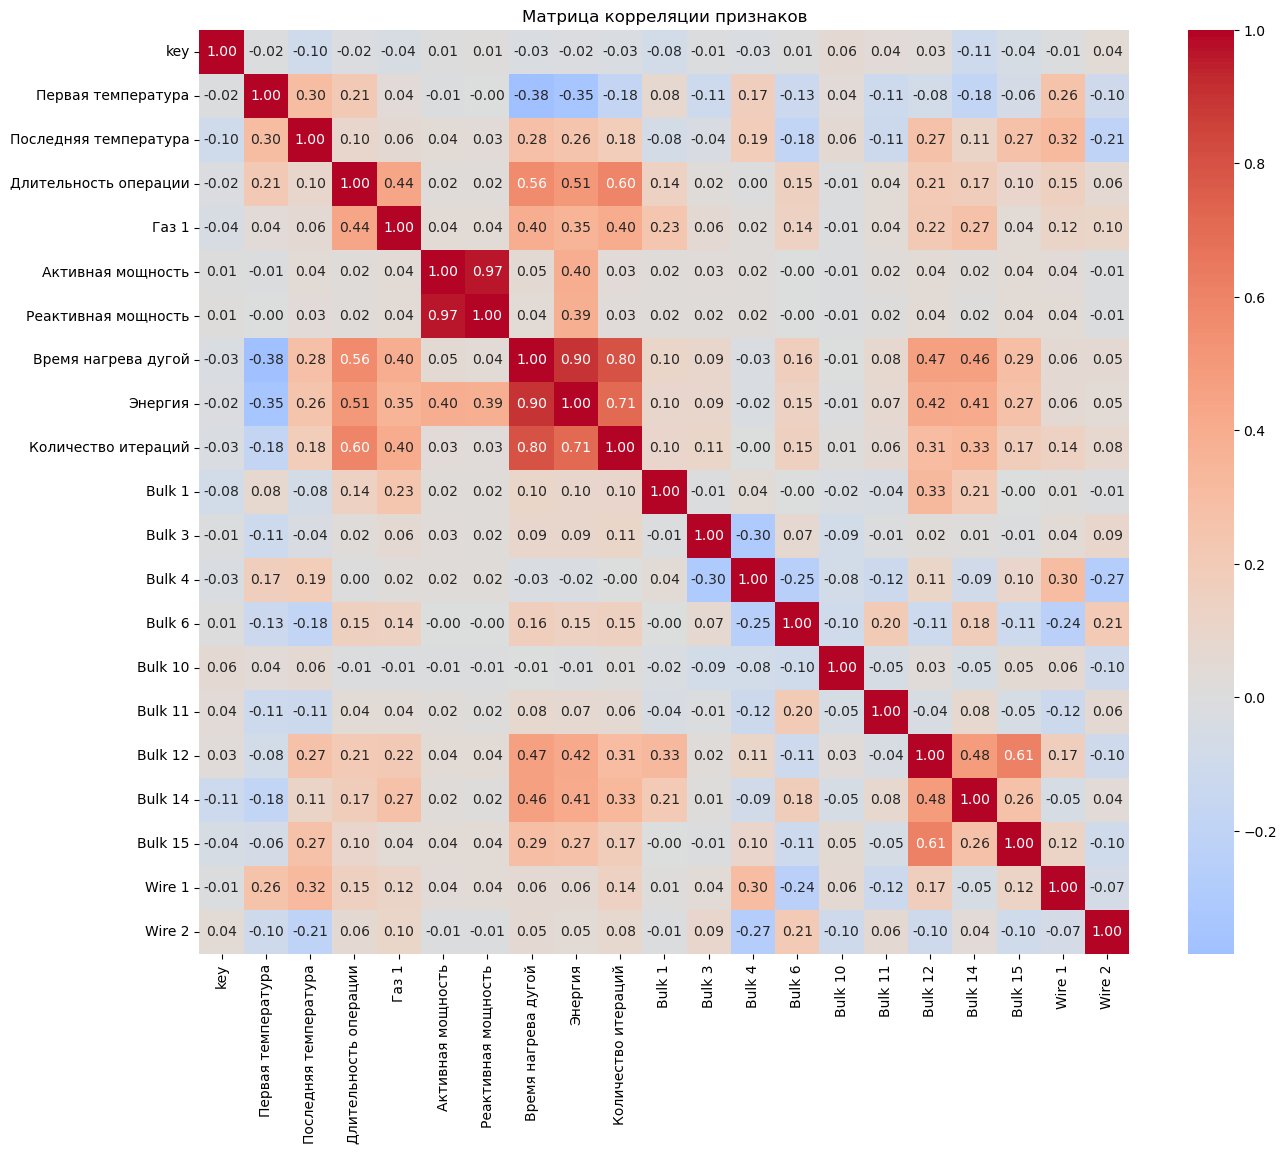

In [211]:
plt.figure(figsize=(15, 12)) 
correlation_matrix = merged_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Матрица корреляции признаков")
plt.show()

Коэффициент корреляции Пирсона выше 0,9 между активной и реактивной мощностями. Когда мультиколлинеарность присутствует в данных, она может вызывать проблемы при анализе или построении моделей, поэтому для надежности модели и улучшения ее точности удалим признак Реактивная мощность.

Также высокий коэффициент корреляции Пирсона наблюдается между энергией и временем нагрева дугой - 0,9 , количеством итераций и временем нагрева дугой - 0,8. Но эти признаки пока оставим, попробуем применить гиперпараметры регуляризации для различных моделей (l1 и l2).

Кроме удаления признака Реактивной мощности, удалим и столбец `key`, он может спровоцировать неявную утечку данных.

In [212]:
merged_data.drop(['Реактивная мощность', 'key'], axis = 1, inplace = True)

In [213]:
merged_data.head()

,Первая температура,Последняя температура,Длительность операции,Газ 1,Активная мощность,Время нагрева дугой,Энергия,Количество итераций,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1571.0,1613.0,0.476111,29.749986,0.607346,0.305000,0.213967,5,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000
1,1581.0,1602.0,0.351389,12.555561,0.534852,0.225278,0.133822,4,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000
2,1596.0,1599.0,0.486944,28.554793,0.812728,0.181944,0.200788,5,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000
3,1601.0,1625.0,0.338889,18.841219,0.676622,0.205833,0.189849,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000
4,1576.0,1602.0,0.426667,5.413692,0.563238,0.241389,0.142269,4,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456


Для удобства анализа основных признаков, повлиявших на температуру, выведем их в виде табличных значений и отсортируем по убыванию:

In [214]:
corr_temp = correlation_matrix['Последняя температура'].sort_values(ascending=False)
corr_temp

Последняя температура    1.000000
Wire 1                   0.317488
Первая температура       0.301882
Время нагрева дугой      0.277953
Bulk 12                  0.266805
Bulk 15                  0.265772
Энергия                  0.255918
Bulk 4                   0.187817
Количество итераций      0.180276
Bulk 14                  0.114893
Длительность операции    0.096126
Bulk 10                  0.061227
Газ 1                    0.059079
Активная мощность        0.039896
Реактивная мощность      0.032716
Bulk 3                  -0.037156
Bulk 1                  -0.075428
key                     -0.096408
Bulk 11                 -0.114936
Bulk 6                  -0.180906
Wire 2                  -0.207242
Name: Последняя температура, dtype: float64

Самое высокое влияние на последнюю температуру оказывает добавление проволочного материала №1. Можно сделать вывод, что именно от состава легирующей смеси зависит целевой признак, именно он определяет свойства конечного продукта и его электропроводимость. Соответственно, смеси, которые используют чаще других при изготовлении партии и будут иметь более высокий коэффициент корреляции. Далее по степени значимости идет на начальная температура и время нагрева дугой. Новый признак - энергия - также имеет влияние на целевую переменную. А вот линейные связи между температурой и объемом инертного газа, активной и реактивной мощности отсутствуют. 

### Промежуточный вывод:

Данные очищены от аномалий, пропуски заполнены, подготовлен датасет для этапа моделирования. Данные проверены на мультиколлинеарность, выявлены признаки, оказывающие максимальное влияние на последнюю температуру. Можно переходить к следующему этапу проекта. 

## Выделение целевого признака и определение набора для тестирования

In [215]:
X = merged_data.drop(['Последняя температура'], axis = 1) #признаки
y = merged_data['Последняя температура'] #целевая переменная

In [216]:
X.columns

Index(['Первая температура', 'Длительность операции', 'Газ 1',
       'Активная мощность', 'Время нагрева дугой', 'Энергия',
       'Количество итераций', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1',
       'Wire 2'],
      dtype='object')

 Определим набор для тестирования:

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=220523) 

Посмотрим на размеры выборок:

In [218]:
X_train.shape

(1743, 18)

In [219]:
X_test.shape

(581, 18)

In [220]:
y_train.shape

(1743,)

In [221]:
y_test.shape

(581,)

## Моделирование

Целевая метрика для оценки модели - MAE. Критерий успешности модели - МАЕ ниже 6.8

### Ridge()

Ridge() или гребневая регрессия уменьшает вклад сильно скоррелированных признаков, но не обнуляет их полностью. Имеет специфически настроенную регуляризацию l2, что позволяет ей быть устойчивой к мультиколлинеарности.

In [222]:
# Функция для оптимизации гиперпараметров с помощью Optuna
def objective(trial):
    # Определение гиперпараметров для оптимизации
    params = {
        'alpha': trial.suggest_float('alpha', 0.001, 10.0), 
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'normalize': trial.suggest_categorical('normalize', [True, False])
        }

    # Создание Pipeline с масштабированием и моделью регрессии
       
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(**params))
    ])

    
    # Оценка модели на кросс-валидации с использованием MAE
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    error = scores.mean()

    return error

In [223]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-06-13 23:02:01,011] A new study created in memory with name: no-name-4d360ab9-f213-4c3d-9ba5-9a8c37f34af8
[I 2023-06-13 23:02:01,049] Trial 0 finished with value: 1593.3595969492744 and parameters: {'alpha': 1.2033609895747606, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 1593.3595969492744.
[I 2023-06-13 23:02:01,089] Trial 1 finished with value: 1593.3595266906568 and parameters: {'alpha': 6.22657582510599, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 1593.3595266906568.
[I 2023-06-13 23:02:01,121] Trial 2 finished with value: 5.988069795524238 and parameters: {'alpha': 9.301960585344748, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.988069795524238.
[I 2023-06-13 23:02:01,150] Trial 3 finished with value: 1593.3595137603281 and parameters: {'alpha': 8.923102266865284, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.988069795524238.
[I 2023-06-13 23:02:01,182] Trial 4

Вывод результатов оптимизации:

In [224]:
best_params_1 = study.best_params
best_error_1 = study.best_value
print('Best Params:', best_params_1)
print('Best MAE:', best_error_1)

Best Params: {'alpha': 0.4833852237825101, 'fit_intercept': True, 'normalize': False}
Best MAE: 5.987386013420384


### RandomForestRegressor()

Модель случайного леса (Random Forest) является мощным алгоритмом машинного обучения, она обладает способностью моделировать сложные зависимости и обеспечивать высокую точность прогнозирования, не требует масштабирования признаков.

In [225]:
def objective(trial):
   
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0)
    }
    
    model = RandomForestRegressor(**params)
                            
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    # Расчет среднего MAE
    error = scores.mean()

    return error

In [226]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-06-13 23:02:01,681] A new study created in memory with name: no-name-b4288a7b-0b9c-4b28-969f-505911b241db
[I 2023-06-13 23:02:21,567] Trial 0 finished with value: 6.3388052405797675 and parameters: {'n_estimators': 978, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.7919081042984181}. Best is trial 0 with value: 6.3388052405797675.
[I 2023-06-13 23:02:47,789] Trial 1 finished with value: 6.228989549030572 and parameters: {'n_estimators': 706, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.9986843387134257}. Best is trial 1 with value: 6.228989549030572.
[I 2023-06-13 23:02:51,858] Trial 2 finished with value: 6.248936073659309 and parameters: {'n_estimators': 149, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.9190082132811995}. Best is trial 1 with value: 6.228989549030572.
[I 2023-06-13 23:02:59,415] Trial 3 finished with value: 6.647641589696295 and parameters: {'n_estimat

Вывод результатов:

In [227]:
best_params_2 = study.best_params
best_error_2 = study.best_value
print('Best Params:', best_params_2)
print('Best MAE:', best_error_2)

Best Params: {'n_estimators': 596, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.7817174523798851}
Best MAE: 6.227124455399005


### CatBoostRegressor()

CatBoost (Categorical Boosting) - это градиентный бустинговый алгоритм. Он не требует масштабирования данных, может работать с пропусками и устойчив к выбросам.

In [228]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 5, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'verbose': False #  во время обучения вывод не будет напечатан.
    }

    model = CatBoostRegressor(**params)

    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    error = scores.mean()

    return error

In [229]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-06-13 23:04:17,173] A new study created in memory with name: no-name-f16ae548-3180-42f5-997b-62263c49050b
[I 2023-06-13 23:04:23,024] Trial 0 finished with value: 6.192793609443155 and parameters: {'learning_rate': 0.24332553176187813, 'depth': 7, 'l2_leaf_reg': 7.3457913216232384, 'iterations': 329}. Best is trial 0 with value: 6.192793609443155.
[I 2023-06-13 23:04:36,761] Trial 1 finished with value: 6.161304146196126 and parameters: {'learning_rate': 0.20655311791070624, 'depth': 7, 'l2_leaf_reg': 6.477322494071053, 'iterations': 779}. Best is trial 1 with value: 6.161304146196126.
[I 2023-06-13 23:04:55,389] Trial 2 finished with value: 5.992590645886811 and parameters: {'learning_rate': 0.024881757442502636, 'depth': 8, 'l2_leaf_reg': 8.698833597362153, 'iterations': 665}. Best is trial 2 with value: 5.992590645886811.
[I 2023-06-13 23:05:04,994] Trial 3 finished with value: 6.359543080385566 and parameters: {'learning_rate': 0.2968930200483029, 'depth': 6, 'l2_leaf_reg':

Вывод результатов:

In [230]:
best_params_3 = study.best_params
best_error_3 = study.best_value
print('Best Params:', best_params_3)
print('Best MAE:', best_error_3)

Best Params: {'learning_rate': 0.12526293811659295, 'depth': 6, 'l2_leaf_reg': 7.520465233989894, 'iterations': 230}
Best MAE: 5.977154844979717


### Выбор лучшей модели

In [231]:
model_scores = pd.DataFrame({'Model':['Ridge', 'RandomForestRegressor', 'CatBoostRegressor'],
                             'MAE': [best_error_1, best_error_2, best_error_3]})
model_scores

,Model,MAE
0,Ridge,5.987386
1,RandomForestRegressor,6.227124
2,CatBoostRegressor,5.977155


Все представленные модели справились с поставленной задачей и достигли оценки МАЕ ниже 6.8, среди них лучшей оказалась - CatBoostRegressor(). Именно ее будем использовать для дальнейшего предсказания температуры стали.

## Оценка на тестовой выборке

### Создание модели с лучшими гиперпараметрами и тестирование

In [232]:
best_model = CatBoostRegressor(**best_params_3, verbose=False)

In [233]:
best_model.fit(X_train, y_train)

In [234]:
predictions = best_model.predict(X_test)

In [235]:
test_mae = mean_absolute_error(y_test, predictions) 
round(test_mae, 2)

5.72

Результат удовлетворительный, сравним эту оценку с ошибкой константной модели. Это позволит понять, насколько обосновано внедрение модели в производство:

### Сравнение с константной моделью

In [236]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
mae_const = mean_absolute_error(y_test, y_pred)

In [237]:
round(mae_const, 2)

7.92

In [238]:
if mae_const > test_mae:
    print('Внедрение модели в производство оправдано, ошибка модели меньше константной')
else:
    print('Модель не подходит для внедрения в производство')

Внедрение модели в производство оправдано, ошибка модели меньше константной


Сохраним модель для дальнейшего использования:

In [239]:
# joblib.dump(best_model, "pred_temp_model.pkl") 

## Анализ модели

### Значимость признаков для модели

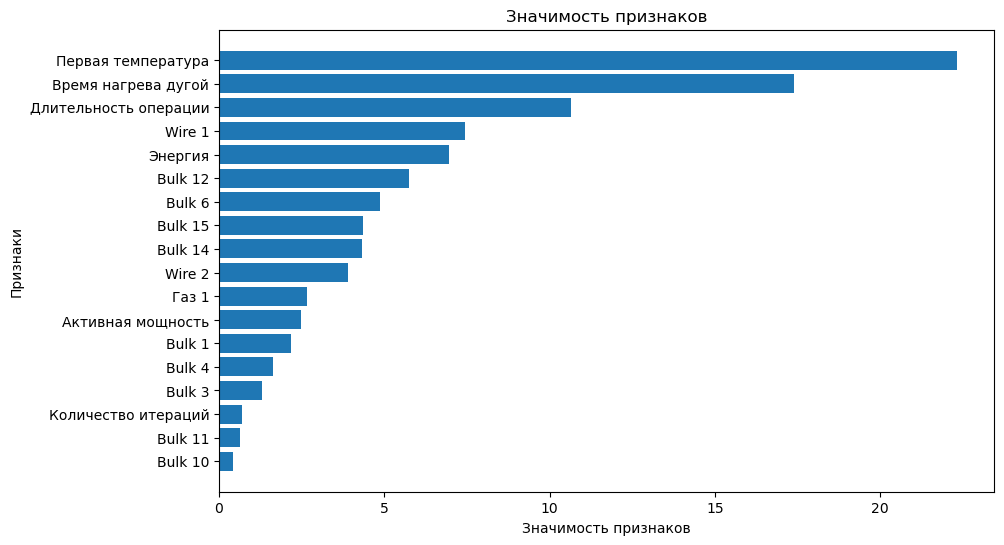

In [240]:
# Получение значимости признаков
feature_importance = best_model.get_feature_importance()

# Получение названий признаков
feature_names = X_train.columns

# Создание отсортированного массива значимости признаков
sorted_idx = np.argsort(feature_importance)

# Создание графика
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx])
plt.yticks(range(len(feature_importance)), feature_names[sorted_idx])
plt.xlabel('Значимость признаков')
plt.ylabel('Признаки')
plt.title('Значимость признаков')
plt.show()

Модель предсказывала целевой признак используя в первую очередь начальную температуру выплавки партии стали, время нагрева дугой и длительность операции нагрева, а только потом - объем проволочного материала №1. При анализе коэффициента корреляции этот признак был на первом месте. Энергия также оказалось для модели достаточно важной фичей, а вот количество итераций для модели значения не имеет.

Подробнее можно увидеть влияние каждого признака на предсказание модели с помощью библиотеки SHAP:

In [241]:
import shap
shap.initjs()

In [242]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

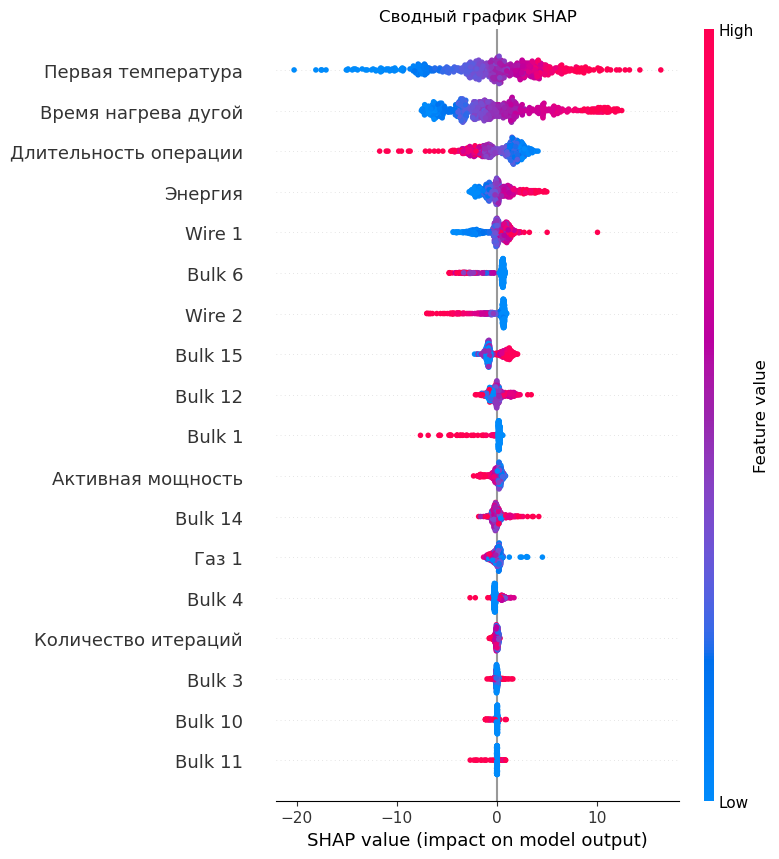

In [243]:
plt.title("Сводный график SHAP")
shap.summary_plot(shap_values, X_test)
plt.show()

На данном графике мы видим, что более низкая начальная температура плавления снижает прогнозируемую конечную температуру и наоборот, более высокая начальная температура завышает предсказание модели. При длительном времени нагрева дугой модель также склонна завышать предсказание. Предсказанную температуру завышает и большой объем проволочных материалов №1 в партии. 

А вот в партиях, где длительность операции самая высокая, модель склонна наоборот занижать предсказание целевого признака. Также занижает целевой признак высокий объем проволочных материалов №2 и смесь металлов №1 и 6.

### Абсолютная ошибка модели

Чтобы посмотреть на абсолютную ошибку модели, а также проанализировать в каких именно партиях модель ошиблась сильнее, созданим новый датасет на основе тестового:

In [244]:
test = X_test.copy() 

In [245]:
test = test.reset_index()

In [246]:
pred_temp = pd.Series(predictions) #массив с предсказаниями завернем Series для присоединения к датасету

In [247]:
y_test = y_test.reset_index() #обновим индексы для значения цены
y_test.drop('index', axis=1, inplace=True)

In [248]:
# присоединим данные
test['real_temp'] = y_test
test['pred_temp'] = pred_temp

In [249]:
test.drop('index', axis=1, inplace=True)

Датасет для анализа ошибок:

In [250]:
test.head()

,Первая температура,Длительность операции,Газ 1,Активная мощность,Время нагрева дугой,Энергия,Количество итераций,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,real_temp,pred_temp
0,1581.0,0.576389,6.815111,0.597711,0.189722,0.130132,6,44.0,0.0,90.0,0.0,0.0,0.0,512.0,249.0,103.0,149.759991,0.000000,1595.0,1586.904611
1,1616.0,1.026944,20.479766,0.914545,0.054167,0.063048,1,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,45.208798,46.679363,1591.0,1581.258441
2,1567.0,0.681389,7.243945,0.740832,0.220556,0.202517,4,0.0,0.0,126.0,0.0,0.0,0.0,255.0,107.0,204.0,135.189591,18.112640,1591.0,1590.419776
3,1568.0,0.408611,14.977648,0.927758,0.222778,0.253346,4,0.0,90.0,0.0,0.0,0.0,0.0,207.0,149.0,152.0,97.100639,0.000000,1593.0,1591.144076
4,1638.0,3.581944,10.867395,0.511097,0.378056,0.237865,7,0.0,152.0,0.0,0.0,0.0,0.0,508.0,204.0,205.0,63.179999,36.403118,1582.0,1608.168637


Добавим столбец с данными об ошибке модели:

In [251]:
test['error'] = test['pred_temp'] - test['real_temp']

In [252]:
test['error'].mean()

-0.0902010049977785

Средняя ошибка практически равна нулю. Посмотрим, как распределена абсолютная ошибка модели:

In [253]:
test['abs_error'] = abs(test['error'])

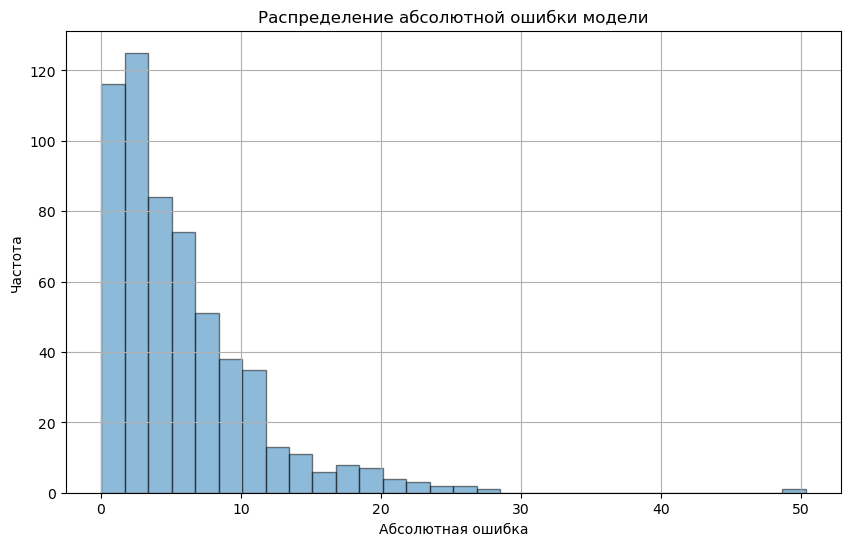

In [254]:
test['abs_error'].hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(10,6))
plt.title('Распределение абсолютной ошибки модели')
plt.xlabel('Абсолютная ошибка')
plt.ylabel('Частота')
plt.show()

На гистограмме видно, что модель в какой-то из партий ошиблась почти на 50 градусов. Посмотрим, что это была за партия и постараемся понять, что привело к такой ошибке:

In [255]:
test.sort_values('abs_error', ascending = False).head()

,Первая температура,Длительность операции,Газ 1,Активная мощность,Время нагрева дугой,Энергия,Количество итераций,Bulk 1,Bulk 3,Bulk 4,...,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,real_temp,pred_temp,error,abs_error
257,1645.0,1.263889,25.377930,0.816734,0.227500,0.219972,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.556640,0.000000,1647.0,1596.686077,-50.313923,50.313923
374,1590.0,1.180000,8.134472,0.667078,0.349167,0.270652,5,0.0,0.0,0.0,...,0.0,334.0,216.0,178.0,100.011597,0.000000,1585.0,1611.922405,26.922405,26.922405
4,1638.0,3.581944,10.867395,0.511097,0.378056,0.237865,7,0.0,152.0,0.0,...,0.0,508.0,204.0,205.0,63.179999,36.403118,1582.0,1608.168637,26.168637,26.168637
263,1538.0,1.357500,18.601690,0.627228,0.593333,0.436097,10,0.0,0.0,0.0,...,0.0,205.0,417.0,204.0,114.354237,0.000000,1621.0,1595.685312,-25.314688,25.314688
504,1621.0,0.531111,10.813276,0.667104,0.262778,0.218341,4,0.0,0.0,0.0,...,0.0,256.0,136.0,222.0,113.255996,150.287293,1623.0,1598.082856,-24.917144,24.917144


Посмотрим, как различные фичи оказали влияние на предсказание температуры в партии с максимальной ошибкой:

In [256]:
shap.force_plot(explainer.expected_value, shap_values[257,:],  X_test.iloc[257,:])

совпали два фактора - слишком долгая длительность операции выплавки стали и участие в процессе легирования только проволочных материалов №1, вследствие чего модель занизила оценку конечной температуры выплавки.

## Вывод:

В ходе исследования были испытаны три модели: Ridge, RandomForestRegressor, CatBoostRegressor. Все модели показали хороший результат на метрике МАЕ, но лучшей моделью оказался - CatBoostRegressor. 

Модель протестирована и готова к запуску в работу.

# Отчет о проделанной работе:

**Цель проекта:**
Оптимизировать производственные расходы фирмы "Как закалялась сталь" за счет уменьшения потребления электроэнергии на этапе обработки стали. Для этого создана модель машинного обучения, которая предсказывает температуру выплавки стали.

В ходе работы по проекту были выполнены все пункты плана.

**Описание трудностей проекта:**

Основной трудностью работы было разобраться в самом технологическом процессе выплавки стали. Понять, как именно решить задачу проекта - с помощью регрессии или с помощью временных рядов. Какие факторы влияют на конечную температуру изготовления одной партии стали и как сгенерировать дополнительные признаки (энергия). Часть вопросов были сняты во время информационных встреч. После анализа корреляционной матрицы, удалось выявить, что основную роль в процессе играют начальная температура и используемые присадки для легирования стали. Они непосредственно влияют на электропроводимость смеси и ее реакцию на нагрев электрической дугой. 

**Ключевые шаги решения проекта:**

- Предобработка данных: удаление аномалий, заполнение пропусков, агрегация данных по столбцу "key" для получения информации о начальной и конечной температуре процесса, а также о времени нагрева дугой и суммарной активной/реактивной мощности. Генерация новых признаков (энергия, длительность процесса, количество итераций в партии), удаление малозначимых присадок.

- Объединение данных в единый датасет, проверка признаков на мультиколлинеарность.

- Выделение целевого признака - конечной температуры процесса выплавки стали. Разделение набора данных на обучающую (75%) и тестовую (25%) выборки.

- Обучение пяти моделей: RANSACRegressor, Ridge, RandomForestRegressor, CatBoostRegressor, StackingRegressor. Все модели показали хорошие результаты на метрике МАЕ, но лучшей моделью оказался CatBoostRegressor.

- Тестирование модели показало МАЕ равное 5,68, что является хорошим результатом. Для сравнения, была также построена константная модель. Однако, лучшая модель CatBoostRegressor() показала значительно более точные предсказания, следовательно, ее внедрение в производство экономически оправдано. 

**Признаки, которые были использованы для обучения модели:**

'Первая температура',  'Длительность операции',  'Газ 1', 'Активная мощность', 'Время нагрева дугой', 'Энергия', 'Количество итераций', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6','Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1','Wire 2'

**Гиперпараметры для обучения:**

Оптимизация гиперпараметров модели CatBoostRegressor() была произведена с помощью библиотеки Optuna. Использовались следующие гиперпараметры:

learning_rate: float(0.01, 0.3) - определяет скорость обучения модели;

depth: int(5, 10) - глубина деревьев в модели;

l2_leaf_reg: float(1.0, 10.0) - определяет регуляризацию l2;

iterations: int(100, 1000)  - определяет количество итераций обучения модели;

verbose: False - во время обучения вывод не будет напечатан.

**Лучшие гиперпараметры: 'learning_rate': 0.06351287985601631, 'depth': 6, 'l2_leaf_reg': 6.488554896431801, 'iterations': 651**

Оценка модели на кросс-валидации - 5,97

**Итоговая метрика:** 5,68



Для оценки важности признаков в модели был проведен анализ. Визуализация важности признаков позволила выявить, что более низкая начальная температура плавления снижает прогнозируемую конечную температуру, в то время как более высокая начальная температура приводит к завышению предсказания модели. Кроме того, длительное время нагрева дугой и большой объем проволочных материалов №1 в партии могут привести к завышению предсказанной температуры. В случае, когда длительность операции плавления стали высокая, модель склонна наоборот занижать предсказание целевого признака.

**Рекомендации по улучшению решения:**

Для дальнейшего улучшения модели требуется больше данных. Дополнительные данные могут помочь уточнить влияние различных факторов на конечную температуру и повысить точность прогнозов. Также стоит рассмотреть возможность использования других моделей и проведение дополнительных экспериментов с гиперпараметрами для поиска более точной модели.
